# Quantum Procedural Generation on a PewPew

Quantum computing will be used for many things, like simulating chemicals or solving complex optimization problems.

Another possible application is procedural generation, such as creating levels or terrain for computer games. Algorithms for procedural generation typically aim to create unique results on every run, while making sure that each output satisfies conditions such as solvability, or just being somehow nice looking.

To do this in the best way possible requires all the tools you can get. New methods provided by quantum computing might then help create the games you are playing in the future. And not just in the far future. You can do it now, with a single qubit!

In this notebook, we do just that. We present a game that is just a simple walking simulator, allowing the player to explore a procedurally generated world. It was inspired by [this work](https://medium.com/qiskit/creating-infinite-worlds-with-quantum-computing-5e998e6d21c2) on procedurally generating terrain using quantum computers, but takes a different approach.

In [1]:
%matplotlib notebook

At its most basic, terrain is just a heightmap. Given some position `x` and `y`, it has a height. In this game we'll look at the terrain from the top down. The height of a pixel will be shown by its brightness. 


Procedural generation creates content using an algorithm. For terrain, this usually means writing a function that determines the height of any point given to it. It has to do this in a way that generates 'nice' terrain. For example, you might want it not to be too jagged, so the height of neighbouring points should be quite similar. The function will typically also use a seed. By changing the seed, you can change the terrain without needing to change the function itself

Put this all together, and we find that we need a function that determines the brightness of any given point. Below is the one we'll use in this game.

In [7]:
# define a function that determines a brightness for any given point
# uses a seed that is a list of four numbers
def get_brightness(x,y,qc,seed):
    qc.data.clear() # empty the circuit
    
    # perform rotations, whose angles depend on x and y
    qc.rx((1/8)*(seed[0]*x-seed[1]*y)*pi,0)
    qc.ry((1/8)*(seed[2]*x+seed[3]*y**2)*pi+pi,0)

    # calculate probability for outcome 1
    qc.measure(0,0)
    p = simulate(qc,shots=1000,get='counts')['1']/1000
    # return brightness depending on this probability
    # the chosen values here are fairly arbitrarily
    if p>0.7:
        if p<0.8:
            return 1
        elif p<0.9:
            return 2
        else:
            return 3
    else:
        return 0

This takes coordinates `x` and `y` and returns a brightness `B`. It assumes that it will have access to two things. A single qubit quantum circuit `qc`, and a list of four numbers called `seed`.

The process is then to first make sure the circuit is empty, and then peform a few single qubit rotations. These are done for angles that depend on the coordinates `x` and `y`. The angles are chosen such that they don't change by more than 45 degrees between neighbouring points.

Finally, the circuit is run and the probability of the outcome `1` is calculated. This is used as the height of the point, and the brightness value is chosen accordingly.

Here is a few examples of it determining the brightness of a small group of pixels, for a randomly generated seed.

In [3]:
from microqiskit import QuantumCircuit, simulate
from math import pi
from random import random

seed = [random() for _ in range(4)]

# initialize circuit used by the function
qc = QuantumCircuit(1,1)

for (x,y) in [(3,3),(3,4),(4,3),(4,4)]:
    print('Brightness at',(x,y),'is B =',get_brightness(x,y,qc,seed))

Brightness at (3, 3) is B = 0
Brightness at (3, 4) is B = 0
Brightness at (4, 3) is B = 0
Brightness at (4, 4) is B = 0


Using the PewPew, we can see what it actually looks like.

<IPython.core.display.Javascript object>


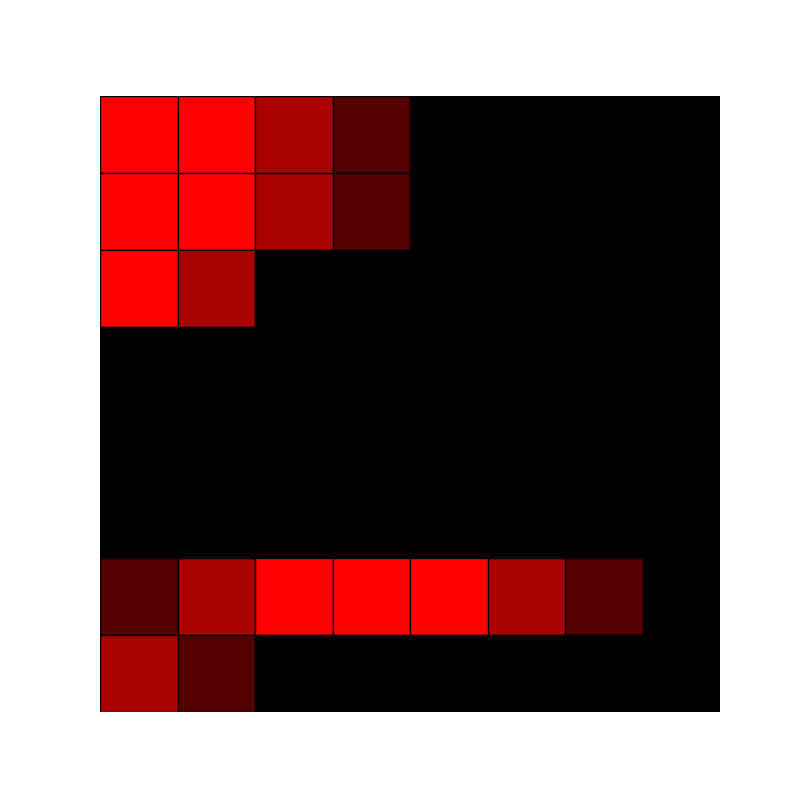

In [4]:
###########################################################
# Replace this comment with the `get_brightness` function #
# if running anywhere other than this notebook            #
###########################################################

import pew
from microqiskit import QuantumCircuit, simulate
from math import pi
from random import random

pew.init()
screen = pew.Pix()

# initialize circuit
qc = QuantumCircuit(1,1)

# set a random seed, composed of four numbers
seed = [random() for _ in range(4)]
    
# loop over all points, and display the brightness
for x in range(8):
    for y in range(8):
        B = get_brightness(x,y,qc,seed)
        screen.pixel(x,y,B)
pew.show(screen)

pew.tick(5)

This showed us one screen's worth of points. To see more, we can use the arrow keys to effectively move the camera: changing the coordinates shown on screen. Specifcially, we'll move by half a screen at a time. This is because it will take time to load the new terrain, and it would be infuriating to move only one pixel at a time.

<IPython.core.display.Javascript object>


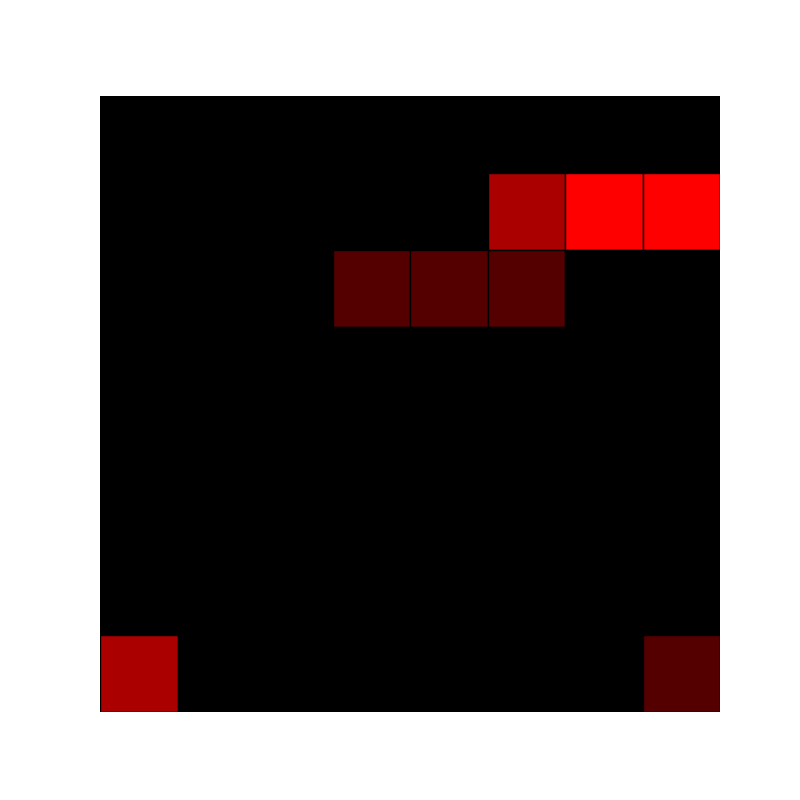

In [ ]:
###########################################################
# Replace this comment with the `get_brightness` function #
# if running anywhere other than this notebook            #
###########################################################

import pew
from microqiskit import QuantumCircuit, simulate
from math import *
from random import random

pew.init()
screen = pew.Pix()

# initialize circuit
qc = QuantumCircuit(1,1)

# set a random seed, composed of four numbers
seed = [(2*(random()<0.5)-1)*(1+random())/2 for _ in range(4)]

# coordinate of the current screen
X,Y = 0,0
    
# loop to allow player to move half a screen
while True:
    
    # arrow keys move to neighbouring screens
    keys = pew.keys()
    if keys!=0:
        if keys&pew.K_UP:
            Y -= 4
        if keys&pew.K_DOWN:
            Y += 4
        if keys&pew.K_LEFT:
            X -= 4
        if keys&pew.K_RIGHT:
            X += 4
    
    # loop over all points on the screen, and display the brightness
    for x in range(8):
        for y in range(8):
            B = get_brightness(x+X,y+Y,qc,seed) # coordinate of the player is accounted for also
            screen.pixel(x,y,B)
    pew.show(screen)

    pew.tick(1/6)

We mentioned before that terrain should be 'nice'. I think the `get_brightness` function here creates terrain which is quite nice, but it could be better. Why not try to improve it?

If you create a new function, consider [submitting it to us](https://github.com/quantumjim/MicroQiskit/issues/new?assignees=quantumjim&labels=hackathon&template=single-qubit-hackathon.md&title=). It could then be added to this notebook and help inspire others.